Predicting the Future of Pokémon: By Michael Holman

Nintendo is one of the world’s leading game development companies and is well known for their flagship series of Mario, Zelda, and Pokémon. Recently, however, the company has been under fire from fans around the world for their recent handling of the Pokémon series. The major decision back in 2019 to not include every Pokémon in further Pokémon games (Sword and Shield having about 400 of the over 900 Pokémon) was surprisingly taken as both [good](https://en.pdvg.it/2020/01/04/pokemon-spada-e-scudo-i-giocatori-competitivi-sono-favorevoli-alla-dexit/) and [bad](https://www.ign.com/articles/2019/11/16/pokemon-sword-and-shield-dexit-controversy-explained) depending on who you talked with. Of interest today are the competitive players of Pokémon and how the future looks for these players.

One problem that arises in card games and long running video game series is a dreaded term called power creep. As a game continues and adds more content the fans are going to want a reason to use newer content rather than their old favorites and the easiest way to make sure they choose new content is to make it stronger than the old content. As more and more content gets released, however, the discrepancy in power between the most recent content and the oldest content gets larger and larger to the point that using older content is non-viable competitively. How does power creep relate to Pokémon then? By adding more Pokémon every generation it stands to reason that some Pokémon are more powerful than others and thus power creep might be an issue or become an issue in the future. One of the main points we will be researching today is whether power creep is currently present in Pokémon and what future generations of Pokémon might look like competitively.


Part 1: Data Collection

The first step in determining evidence of power creep is to compare the base stats of all Pokémon as of the current generation then group and compare them based on the generation they originated from. There are plenty of websites with Pokémon information on them such as [Pokemon Database](https://pokemondb.net/pokedex/national) and [Serebii](https://serebii.net/pokedex-swsh/) but today we are using [Bulbapedia](https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_National_Pok%C3%A9dex_number) as they have a stats database already available on one page.

We’ll import libraries that will be necessary for the project (this includes every step, not just data collection).

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sma
import warnings
warnings.filterwarnings('ignore')

The first step is to send a request for the HTML of Bulbapedia, then reading that HTML using BeautifulSoup and Pandas’ built-in readers. This will translate all the data on the page into a DataFrame for us to access. Then  we do some preprocessing of our data by dropping unnecessary columns (we don’t need the images of the pokemon for this), renaming the columns for easier use later, and most importantly dropping unnecessary rows.

Some Pokémon are listed twice under the same ID as they have abilities that change their form to temporarily increase their stats under certain conditions. As each Pokémon has different circumstances for these stat changes, we would need to inspect each duplicate entry individually to figure out how best to count their effective stats. Today we are only interested in their base stats, not accounting for items, abilities, forms, or EV values that might influence an individual Pokémon; the primary form (listed first) will be kept while duplicates are dropped.

In [3]:
content = requests.get("https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_base_stats_(Generation_VIII-present)").content
pkmnstats = pd.read_html(str(BeautifulSoup(content).find("table", class_="sortable")))[0]
pkmnstats.drop_duplicates(subset=['#'], inplace=True)
pkmnstats.rename({"#":"ID","Pokémon":"Name"}, axis=1, inplace=True)
pkmnstats.reset_index(inplace=True)
pkmnstats.drop("Unnamed: 1", axis=1, inplace=True)
pkmnstats.drop("index", axis=1, inplace=True)
pkmnstats

,ID,Name,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average
0,1,Bulbasaur,45,49,49,65,65,45,318,53.00
1,2,Ivysaur,60,62,63,80,80,60,405,67.50
2,3,Venusaur,80,82,83,100,100,80,525,87.50
3,4,Charmander,39,52,43,60,50,65,309,51.50
4,5,Charmeleon,58,64,58,80,65,80,405,67.50
...,...,...,...,...,...,...,...,...,...,...
900,901,Ursaluna,130,140,105,45,80,50,550,91.67
901,902,Basculegion (Male),120,112,65,80,75,78,530,88.33
902,903,Sneasler,80,130,60,40,80,120,510,85.00
903,904,Overqwil,85,115,95,65,65,85,510,85.00


Each stat is fairly self-explanatory for those familiar with [RPGs](https://en.wikipedia.org/wiki/Role-playing_game) and video games. We have the ID of the Pokémon which represents the typical order they are listed in-game (not accounting for the latest generation cutting some Pokémon, of course), lower IDs are generally Pokémon from earlier generations while higher IDs are from later generations. HP stands for hit points, how many hits a creature can take before reaching 0 and being incapacitated. Attack and Sp. Attack dictate how many hit points they will take away from their opponent when they use an offensive move. Defense and Sp. Defense mitigate number of hit points removed when targeted by an offensive move with Defense mitigating Attack and Sp. Defense mitigating Sp. Attack. Speed helps decide which Pokémon will take their turn first. Luckily for us the database also includes the total stats and average stats of each Pokémon so these will not need to be calculated later.

Originally, we had planned on using Serebii's database as each Pokémon was listed in sequential file order for easy access and each file/page had all the necessary data for our graphs and more. Unfortunately, my computer could not read several hundred HTML files in a reasonable time. We then moved to Bulbapedia but the problem with this website is that not all the information we want is all on one page. As such we will need to add in new information by hand later. For now, though, our initial data has been loaded and is ready for display.

Part 2: Data Representation

First order of business now that we have our data is to represent it. We will be doing this two ways: comparing ID to total stats in a scatter plot and finding the spread over each stat using violin plots.

Our scatter plot comparing ID to total stats should allow us to see if there are any noticeable trends as ID, and subsequently generation, increases. We will likely have to come back to this graph later to better categorize our data which will make trends more obvious, but for now this is preliminary representation.

Our violin plots won’t tell us anything directly about our original question, whether power creep exists in Pokémon, but this might help capture other interesting trends and lead to other insights and questions for the future. An additional benefit to this graph is to better highlight existence of outliers and range of Pokémon stats.

The code below generates our two plots using matplotlib and pandas’ built-in plotting capabilities.

(-10.0, 60.0)

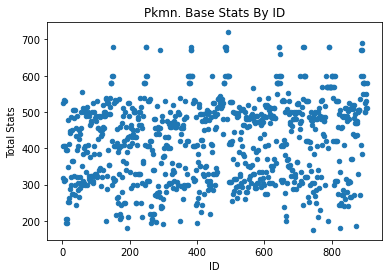

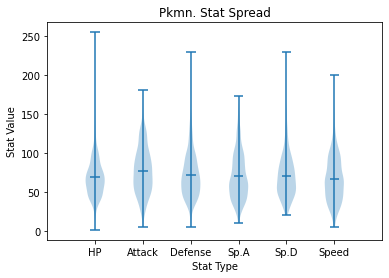

In [4]:
pkmnstats.plot(x="ID",y="Total",kind="scatter",title="Pkmn. Base Stats By ID",xlabel="ID",ylabel="Total Stats")
temp=[0,10,20,30,40,50]
statLbl = ["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed"]
statValue = []
fig, ax = plt.subplots()
for s in statLbl:
    statValue.append(pkmnstats[s])
ax.violinplot(statValue,temp,widths=4,showmeans=True)
ax.set_xlabel("Stat Type")
ax.set_ylabel("Stat Value")
ax.set_title("Pkmn. Stat Spread")
statLbl[3]="Sp.A"
statLbl[4]="Sp.D"
ax.set_xticks(np.arange(0, 10*len(statLbl), 10), labels=statLbl)
ax.set_xlim(-10, 10*len(statLbl))

Unsurprisingly, our initial plots don’t indicate any extremely evident patterns. If power creep was so evident one line plot could show proof of it there would have been complaints about it. Does this mean power creep doesn’t exist? We can’t be sure of this either, more data and charts are necessary for any definitive conclusions.

What did we learn from these plots then? First, we learned about the existence of clear outliers which we will need to identify the cause of in the next section. These outliers are evident both as points in the scatter plot far above the larger cluster and as the cause of the large ranges of the violin plots. The second is a bit harder to notice but with some background knowledge of Pokémon we find this: within each generation there appears to be a positive correlation between ID and total stats. Looking at the graph you can see 8 different positive trend lines and eight groups of outliers, the same number as the number of Pokémon generations. This might also help us identify groups of Pokémon and even determine the outliers easier.


Part 3: Initial Data Analysis

It’s time to identify some outliers… but what is an outlier? Outliers are hard to define as there are many characteristics of them before we can even consider including them or not. Consulting the list of banned and restricted Pokémon in competitive matches we find that most [mythical](https://bulbapedia.bulbagarden.net/wiki/Mythical_Pok%C3%A9mon) Pokémon are banned while most [legendaries](https://bulbapedia.bulbagarden.net/wiki/Legendary_Pok%C3%A9mon) are restricted. These Pokémon all have fairly high base stats, but there are non-legendary Pokémon with stats this high that aren’t restricted ([pseudo-legendaries](https://bulbapedia.bulbagarden.net/wiki/Pseudo-legendary_Pok%C3%A9mon) for example) so should we include them in the same group? For now we’ll manually label the banned and restricted Pokémon one way and leave the rest alone.

There’s another group of Pokémon that might be messing up our stats as well. One of the major features of Pokémon is evolution: as Pokémon satisfy certain requirements they evolve into entirely different Pokémon with new moves and better stats. As these evolutions all have better stats than their evolved forms nobody uses the unevolved forms competitively, thus the evolved forms should be labeled differently.

Performing a request to Serebii and Bulbapedia and adding in two more columns to our data should help identify groups, then we plot the scatter plot again with these groups in mind. The limited column will tell us if competitive has deemed a Pokémon too strong, the evolved column will tell us if this Pokémon is fully evolved (and cannot evolve again).


In [5]:
pkmnstats2 = pkmnstats.copy()
pkmnstats2["Limited"] = False
pkmnstats2["Evolved"] = False
content = requests.get("https://www.serebii.net/swordshield/rankedbattle/series10.shtml").content
temp = pd.read_html(str(BeautifulSoup(content).find_all("table", class_="tab")[1]))[0]
for index, row in temp.iterrows():
    if index>0:
        pkmnstats2.loc[pkmnstats2["ID"]==int(row[0][1:4]), "Limited"] = True
temp = pd.read_html(str(BeautifulSoup(content).find_all("table", class_="tab")[2]))[0]
for index, row in temp.iterrows():
    if index>0:
        pkmnstats2.loc[pkmnstats2["ID"]==int(row[0][1:4]), "Limited"] = True
content = requests.get("https://bulbapedia.bulbagarden.net/wiki/List_of_fully_evolved_Pok%C3%A9mon_by_base_stats").content
temp = pd.read_html(str(BeautifulSoup(content).find("table", class_="sortable")))[0]
for index, row in temp.iterrows():
    pkmnstats2.loc[pkmnstats2["ID"]==int(row["#"]), "Evolved"] = True
pkmnstats2.loc[pkmnstats2["Limited"]==True].head()

,ID,Name,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Limited,Evolved
149,150,Mewtwo,106,110,90,154,90,130,680,113.33,True,True
150,151,Mew,100,100,100,100,100,100,600,100.00,True,True
248,249,Lugia,106,90,130,90,154,110,680,113.33,True,True
249,250,Ho-Oh,106,130,90,110,154,90,680,113.33,True,True
250,251,Celebi,100,100,100,100,100,100,600,100.00,True,True


The chart displayed above lists a few of the limited pokemon: note their high base stats and the fact they are all either legendary or mythical.

Part 4: Hypothesis Testing

With some categorized data we can finally test our hypothesis: power creep is evident in Pokémon with stats increasing as newer Pokémon are released. This, of course, means our null hypothesis would be that no correlation exists between Pokémon ID and overall stats. We’ll perform a linear regression algorithm for each of our three major categories of Pokémon: all, fully evolved and no limited Pokémon, and limited only. Should our slope have an absolute value less than 0.05 then we will be forced to reject the null hypothesis.

First, all Pokémon:

In [6]:
reg = LinearRegression().fit(pkmnstats2[["ID"]].values,pkmnstats2["Total"])
print("The linear regression equation is as follows (where y represents total stats and x represents ID):")
print("y = "+str(reg.coef_[0])+"x + ("+str(reg.intercept_)+")")
regX = sma.OLS(pkmnstats2["Total"], sma.add_constant(pkmnstats2["ID"])).fit()
print(regX.summary())

The linear regression equation is as follows (where y represents total stats and x represents ID):
y = 0.07343818148084952x + (390.5247689825453)
                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     27.43
Date:                Mon, 16 May 2022   Prob (F-statistic):           2.03e-07
Time:                        14:05:57   Log-Likelihood:                -5538.8
No. Observations:                 905   AIC:                         1.108e+04
Df Residuals:                     903   BIC:                         1.109e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.0

Then fully evolved non-limited Pokémon:

In [7]:
reg2 = LinearRegression().fit(pkmnstats2.loc[(pkmnstats2["Evolved"]==True)&(pkmnstats2["Limited"]==False)][["ID"]].values,\
                             pkmnstats2.loc[(pkmnstats2["Evolved"]==True)&(pkmnstats2["Limited"]==False)]["Total"])
print("The linear regression equation is as follows (where y represents total stats and x represents ID):")
print("y = "+str(reg2.coef_[0])+"x + ("+str(reg2.intercept_)+")")
regX2 = sma.OLS(pkmnstats2.loc[(pkmnstats2["Evolved"]==True)&(pkmnstats2["Limited"]==False)]["Total"],\
               sma.add_constant(pkmnstats2.loc[(pkmnstats2["Evolved"]==True)&(pkmnstats2["Limited"]==False)]["ID"])).fit()
print(regX2.summary())

The linear regression equation is as follows (where y represents total stats and x represents ID):
y = 0.04841292450489914x + (471.8269440195884)
                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     22.91
Date:                Mon, 16 May 2022   Prob (F-statistic):           2.29e-06
Time:                        14:05:59   Log-Likelihood:                -2522.8
No. Observations:                 463   AIC:                             5050.
Df Residuals:                     461   BIC:                             5058.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.0

Now just the limited Pokémon:

In [8]:
reg3 = LinearRegression().fit(pkmnstats2.loc[(pkmnstats2["Limited"]==True)][["ID"]].values,\
                             pkmnstats2.loc[(pkmnstats2["Limited"]==True)]["Total"])
print("The linear regression equation is as follows (where y represents total stats and x represents ID):")
print("y = "+str(reg3.coef_[0])+"x + ("+str(reg3.intercept_)+")")
regX3 = sma.OLS(pkmnstats2.loc[(pkmnstats2["Limited"]==True)]["Total"],\
               sma.add_constant(pkmnstats2.loc[(pkmnstats2["Limited"]==True)]["ID"])).fit()
print(regX3.summary())

The linear regression equation is as follows (where y represents total stats and x represents ID):
y = -0.1381888046486698x + (698.3919355431143)
                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3.470
Date:                Mon, 16 May 2022   Prob (F-statistic):             0.0707
Time:                        14:06:02   Log-Likelihood:                -228.59
No. Observations:                  38   AIC:                             461.2
Df Residuals:                      36   BIC:                             464.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.0

And finally we’ll display it all on a colorful scatter/line plot:

The black line represents the linear regression line for all Pokémon


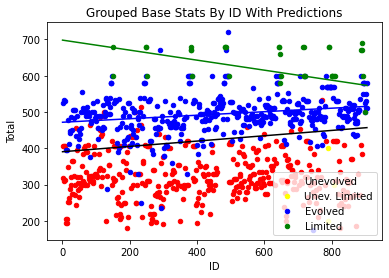

In [9]:
colors = ["red", "yellow", "blue", "green"]
labels = ["Unevolved", "Unev. Limited", "Evolved", "Limited"]
fig, ax = plt.subplots()
for value1, group1 in pkmnstats2.groupby("Evolved"):
    for value2, group2 in group1.groupby("Limited"):
        group2.plot(x="ID", y="Total", kind="scatter", ax=ax, label=labels[2*value1+value2], c=colors[2*value1+value2])
plt.plot(pkmnstats2["ID"], reg.predict(pkmnstats2[["ID"]]), color="black")
plt.plot(pkmnstats2["ID"], reg2.predict(pkmnstats2[["ID"]]), color="blue")
plt.plot(pkmnstats2["ID"], reg3.predict(pkmnstats2[["ID"]]), color="green")
ax.set_title("Grouped Base Stats By ID With Predictions")
print("The black line represents the linear regression line for all Pokémon")

Part 5: Communication and Conclusions

So what does all of our data mean? Judging by our linear regression lines it seems there is indeed a positive correlation between ID and base stats after all. This positive correlation holds for Pokémon overall and for the main group of competitive Pokémon, evolved non-limited Pokémon. Surprisingly though, there is a negative correlation between ID and limited Pokémon meaning more recent limited Pokémon are generally weaker than older limited Pokémon.

Are we sure we can trust our data? Judging by the p-values we can safely reject our null hypothesis as there is a less than .1% chance of this data occurring without a correlation existing, a low enough chance for us to reject that possibility. We satisfy this p value for both Pokémon overall as well as the main group of Pokémon (evolved non-limited Pokémon) but not for limited Pokémon’s linear regression. Perhaps there is not enough data or perhaps there are other factors at work, either way we cannot safely conclude anything about our limited Pokémon despite their linear regression data. Thus we can conclude there is indeed a positive correlation between stats and ID (or recentness) in Pokémon.

Does this mean power creep exists in Pokémon? Not definitively, no. The first major problem with this theory is that power creep is only a problem if the people who it affects (competitive players) think it is a problem, otherwise it is just an interesting statistical quirk. The second major problem is that the correlation itself is very minor, over 8 whole generations and 25 years the average base stat totals have only increased by about 40 for competitive Pokémon which is negligible for most competitive situations.

What does this data mean then? For starters we can use it as a baseline to compare our Pokémon from now on; Pokémon that are below these stats should rarely be considered for competitive use. We can also use this data for more fun projects, such as predicting future generations’ base stats and creating more accurate Pokémon [ROM hacks](https://en.wikipedia.org/wiki/ROM_hacking#:~:text=ROM%20hacking%20is%20the%20process,%2C%20and%2For%20other%20elements.). We can also safely say that we now know what to watch for in future generations and can plan preemptively for changes in the competitive scene. Otherwise though, more data and research would be needed for any major breakthroughs.

For further study it might be worth checking out Pokémon ROMs and comparing them to find the most “accurate” versions. It might also be worth comparing the stats of Pokémon over each generation as stats sometimes change between generations to accommodate new mechanics and to fix power creep. Finally, additional insights might be revealed when comparing Pokémon in more detail such as considering their evolution states (fully or not fully evolved), potential for mega evolution (which temporarily increasing base stats), and even their abilities and EVs which can affect their effective stats compared to their base stats. To take this project a step further, we could predict Pokémon stats based on type and predict an entire regions’ worth of Pokémon using average number of Pokémon per type combination and stats per type. There are always more trends to be found in data and thus there are always more predictions to be done.
